[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel,
    'RBF': RBF
    
}

In [3]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Unnamed: 16,Rep7,Rep8,Rep9,RBS6,index,Pred Mean,Pred Std,Pred UCB
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
5,5,TGTAAGAAGGAGATATACAT,RBS_1by1_5,0.156597,0.129608,0.447555,0.103395,0.222683,0.366914,0.237792,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
6,6,TATAAGAAGGAGATATACAT,RBS_1by1_6,1.296223,1.330318,0.946361,0.887157,1.269821,1.700506,1.238398,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
7,7,TTGAAGAAGGAGATATACAT,RBS_1by1_8,1.541914,1.703705,NaN,2.075267,1.852707,2.272039,1.889127,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
8,8,TTAAAGAAGGAGATATACAT,RBS_1by1_9,0.477942,0.625771,1.389786,0.385242,0.305004,0.465392,0.608190,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
9,9,TTTCAGAAGGAGATATACAT,RBS_1by1_10,1.505403,0.957867,0.631509,1.569340,1.254679,1.958256,1.312842,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(265, 26)

(array([19., 43., 40., 31., 38., 42., 31., 11.,  9.,  1.]),
 array([-1.73349523, -1.29657224, -0.85964925, -0.42272625,  0.01419674,
         0.45111973,  0.88804273,  1.32496572,  1.76188871,  2.19881171,
         2.6357347 ]),
 <a list of 10 Patch objects>)

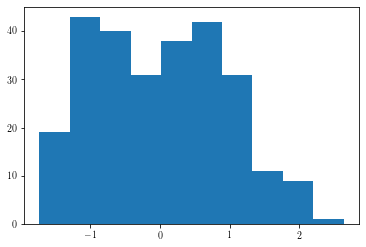

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score, 'coverage rate']

gpr = GPR_Predictor(df, kernel_name = kernel)
# gpr = GPR_Predictor(df, train_idx=df['Round'] == 0, test_idx=df['Round'] == 1, kernel_name = kernel)

# num_split = 5
# num_repeat = 5
# s_list = [0,1]
# # alpha_list = [0.5]
# alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list =[3,6]
# # sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
# sigma_0_list = [0.5, 1, 2]

In [7]:
num_split = 5
num_repeat = 10
s_list = [1]
# alpha_list = [0.5]
alpha_list= [2] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list =[6]
# sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
sigma_0_list = [1]
                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat,
                                      kernel_norm_flag=[True], centering_flag=[True, False], unit_norm_flag=[True, False],
                                      alpha_list= alpha_list, l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=200)

centering_flag:  True
unit_norm_flag:  True
init kernel
1
centering_flag:  True
unit_norm_flag:  True
init kernel
2
centering_flag:  True
unit_norm_flag:  True
init kernel
3
centering_flag:  True
unit_norm_flag:  True
init kernel
4
centering_flag:  True
unit_norm_flag:  True
init kernel
5
centering_flag:  True
unit_norm_flag:  False
init kernel
6
centering_flag:  True
unit_norm_flag:  False
init kernel
7
centering_flag:  True
unit_norm_flag:  False
init kernel
8
centering_flag:  True
unit_norm_flag:  False
init kernel
9
centering_flag:  True
unit_norm_flag:  False
init kernel
10
centering_flag:  False
unit_norm_flag:  True
init kernel
11
centering_flag:  False
unit_norm_flag:  True
init kernel
12
centering_flag:  False
unit_norm_flag:  True
init kernel
13
centering_flag:  False
unit_norm_flag:  True
init kernel
14
centering_flag:  False
unit_norm_flag:  True
init kernel
15
centering_flag:  False
unit_norm_flag:  False
init kernel
16
centering_flag:  False
unit_norm_flag:  False
init ke

In [8]:
import pickle

# with open('repeated_kfold_wd_shift_round01.pickle', 'wb') as handle:
with open('repeated_kfold_RBF_round01_kenrelNormAdjust.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('repeated_kfold_wd_shift_round01.pickle', 'rb') as handle:
with open('repeated_kfold_RBF_round01_kenrelNormAdjust.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [9]:
result_pkl.loc[dict(train_test = 'Test')].loc[dict(eva_metric='coverage rate')]

<xarray.DataArray (eva_on: 2, kernel_norm_flag: 1, centering_flag: 2, unit_norm_flag: 2, alpha: 1, rbf_lengthscale: 1, l: 1, s: 1, sigma_0: 1, num_repeat: 10, num_split: 5)>
array([[[[[[[[[[[0.85835694, 0.83364839, 0.83556405, 0.83601896,
                 0.87570093],
                [0.83648393, 0.84080076, 0.85489834, 0.83269231,
                 0.86591124],
                [0.8436019 , 0.84030418, 0.84814815, 0.85795996,
                 0.8365019 ],
                [0.84842707, 0.84299065, 0.84825636, 0.84723524,
                 0.8376561 ],
                [0.84034417, 0.83831776, 0.84330484, 0.8547329 ,
                 0.84790875],
                [0.84629803, 0.83648393, 0.84130019, 0.84593573,
                 0.86496695],
                [0.84774436, 0.83938815, 0.84049666, 0.85514019,
                 0.84448633],
                [0.82837967, 0.84425451, 0.84492481, 0.85098407,
                 0.84354383],
                [0.84175405, 0.86766076, 0.8241966 , 0.85205993,
                 0.84134615],
                [0.81975072, 0.83843212, 0.86174242, 0.84593573,
                 0.86175115]]]]]]],
...
          [[[[[[[0.71954674, 0.6852552 , 0.73040153, 0.7042654 ,
                 0.74485981],
                [0.72778828, 0.71115348, 0.71719039, 0.68557692,
                 0.71671388],
                [0.74123223, 0.70342205, 0.71944444, 0.69685415,
                 0.71197719],
                [0.73117255, 0.70934579, 0.70876532, 0.72727273,
                 0.70028818],
                [0.70458891, 0.70280374, 0.72364672, 0.72164948,
                 0.72338403],
                [0.71602624, 0.69943289, 0.67399618, 0.71644612,
                 0.72804533],
                [0.72086466, 0.69885277, 0.69627507, 0.72242991,
                 0.70028275],
                [0.70373921, 0.6980057 , 0.72932331, 0.70477976,
                 0.68426013],
                [0.73117255, 0.71202237, 0.66824197, 0.73314607,
                 0.68846154],
                [0.66634708, 0.70458891, 0.73863636, 0.71928166,
                 0.70967742]]]]]]]]]]])
Coordinates:
    train_test        <U5 'Test'
  * eva_on            (eva_on) <U7 'samples' 'seq'
    eva_metric        <U13 'coverage rate'
  * kernel_norm_flag  (kernel_norm_flag) bool True
  * centering_flag    (centering_flag) bool True False
  * unit_norm_flag    (unit_norm_flag) bool True False
  * alpha             (alpha) int64 2
  * rbf_lengthscale   (rbf_lengthscale) int64 1
  * l                 (l) int64 6
  * s                 (s) int64 1
  * sigma_0           (sigma_0) int64 1
  * num_repeat        (num_repeat) int64 0 1 2 3 4 5 6 7 8 9
  * num_split         (num_split) int64 0 1 2 3 4

In [27]:
result_pkl[1][1][2].loc[dict(centering_flag = False)].loc[dict(unit_norm_flag = True)].mean(axis = -1).mean(axis = -1)
# result_pkl[1][1][2].mean(axis = -1).std(axis = -1)

<xarray.DataArray (kernel_norm_flag: 1, alpha: 1, rbf_lengthscale: 1, l: 1, s: 1, sigma_0: 1)>
array([[[[[[0.71790586]]]]]])
Coordinates:
    train_test        <U5 'Test'
    eva_on            <U7 'seq'
    eva_metric        <U13 'coverage rate'
  * kernel_norm_flag  (kernel_norm_flag) bool True
    centering_flag    bool False
    unit_norm_flag    bool True
  * alpha             (alpha) int64 2
  * rbf_lengthscale   (rbf_lengthscale) int64 1
  * l                 (l) int64 6
  * s                 (s) int64 1
  * sigma_0           (sigma_0) int64 1

(array([6., 2., 0., 0., 0., 0., 6., 4., 4., 2.]),
 array([0.15367116, 0.22961459, 0.30555802, 0.38150144, 0.45744487,
        0.5333883 , 0.60933173, 0.68527516, 0.76121859, 0.83716201,
        0.91310544]),
 <a list of 10 Patch objects>)

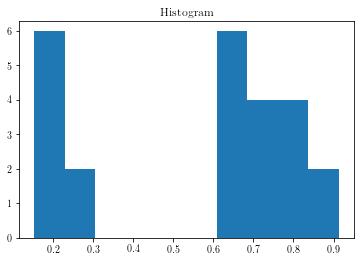

In [11]:
# result_pkl[1][1][2].loc[dict(s = 1)].loc[dict(l=6)].mean(axis = -1).mean(axis = -1).plot()
result_pkl[1].mean(axis = -1).mean(axis = -1).plot()